<a href="https://colab.research.google.com/github/MahenJayawardana/DL_Assignment/blob/IT20612450/DL_Assignment_Attempt_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import os
import pandas as pd
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
# URLs for data and metadata
image_data_url = "https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_JPEG.zip"
metadata_url = "https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv"

In [3]:
# Directory for data
data_dir = './data'

In [4]:
# Download and unzip data if it doesn't exist
if not os.path.exists(os.path.join(data_dir, 'ISIC_2020_Training_JPEG')):
    os.system(f"wget {image_data_url} -P {data_dir}")
    os.system(f"unzip {os.path.join(data_dir, 'ISIC_2020_Training_JPEG.zip')} -d {data_dir}")

In [5]:
# Read metadata
metadata = pd.read_csv(metadata_url)

In [6]:
# Map 'nevus' as 'nevus' and 'melanoma' as 'melanoma'
metadata['diagnosis'] = metadata['diagnosis'].apply(lambda x: x.lower())

In [7]:
# Filter out 'nevus' and 'melanoma' classes only
valid_classes = ['nevus', 'melanoma']
metadata_filtered = metadata[metadata['diagnosis'].isin(valid_classes)]
metadata_filtered = shuffle(metadata_filtered, random_state=42)

In [9]:
# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    metadata_filtered['image_name'], (metadata_filtered['diagnosis'] == 'melanoma').astype(int),
    test_size=0.2, random_state=42, stratify=metadata_filtered['diagnosis']
)

In [10]:
# Directories for training and validation data
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'validation')

In [11]:
# Create directories for classes
for class_name in valid_classes:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

In [12]:
# Copy images to class directories
for image_name, label in zip(X_train, y_train):
    class_name = 'melanoma' if label == 1 else 'nevus'
    source_path = os.path.join(data_dir, 'train', f'{image_name}.jpg')
    destination_path = os.path.join(train_dir, class_name, f'{image_name}.jpg')
    if os.path.exists(source_path):
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy(source_path, destination_path)
    else:
        print(f"Image not found: {source_path}")

for image_name, label in zip(X_val, y_val):
    class_name = 'melanoma' if label == 1 else 'nevus'
    source_path = os.path.join(data_dir, 'train', f'{image_name}.jpg')
    destination_path = os.path.join(val_dir, class_name, f'{image_name}.jpg')
    if os.path.exists(source_path):
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)
        shutil.copy(source_path, destination_path)
    else:
        print(f"Image not found: {source_path}")

In [13]:
# Class distribution in the training and validation sets
class_distribution_train = y_train.value_counts()
class_distribution_val = y_val.value_counts()
print("Class distribution in the training set:\n", class_distribution_train)
print("\nClass distribution in the validation set:\n", class_distribution_val)

Class distribution in the training set:
 0    4154
1     467
Name: diagnosis, dtype: int64

Class distribution in the validation set:
 0    1039
1     117
Name: diagnosis, dtype: int64


In [16]:
# Image dimensions and batch size
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

In [17]:
# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=valid_classes
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    classes=valid_classes
)


Found 4621 images belonging to 2 classes.
Found 1156 images belonging to 2 classes.


In [18]:
# Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=30,
    # callbacks=[EarlyStopping(patience=3)]
)

Epoch 1/30
144/144 [==============================] - 158s 1s/step - loss: 0.1722 - accuracy: 0.9338 - val_loss: 0.1920 - val_accuracy: 0.9349
Epoch 2/30
144/144 [==============================] - 172s 1s/step - loss: 0.1613 - accuracy: 0.9362 - val_loss: 0.1766 - val_accuracy: 0.9384
Epoch 3/30
144/144 [==============================] - 148s 1s/step - loss: 0.1599 - accuracy: 0.9359 - val_loss: 0.1855 - val_accuracy: 0.9332
Epoch 4/30
144/144 [==============================] - 146s 1s/step - loss: 0.1631 - accuracy: 0.9351 - val_loss: 0.1828 - val_accuracy: 0.9392
Epoch 5/30
144/144 [==============================] - 150s 1s/step - loss: 0.1557 - accuracy: 0.9416 - val_loss: 0.1781 - val_accuracy: 0.9340
Epoch 6/30
144/144 [==============================] - 168s 1s/step - loss: 0.1585 - accuracy: 0.9375 - val_loss: 0.1919 - val_accuracy: 0.9280
Epoch 7/30
144/144 [==============================] - 174s 1s/step - loss: 0.1544 - accuracy: 0.9416 - val_loss: 0.1773 - val_accuracy: 0.9280

In [22]:
# Evaluate the model
evaluation = model.evaluate(validation_generator)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

37/37 [==============================] - 27s 732ms/step - loss: 0.1905 - accuracy: 0.9221
Validation Loss: 0.19053137302398682
Validation Accuracy: 0.9221453070640564


In [23]:
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

image_path = '/content/data/train/melanoma/ISIC_0250839.jpg'

# Load and preprocess the image
img = image.load_img(image_path, target_size=(img_width, img_height))
img = image.img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)  # Add batch dimension

# Predict the class
prediction = model.predict(img)

if prediction > 0.5:
    print("Melanoma")
else:
    print("Nevus")


1/1 [==============================] - 0s 242ms/step
Nevus


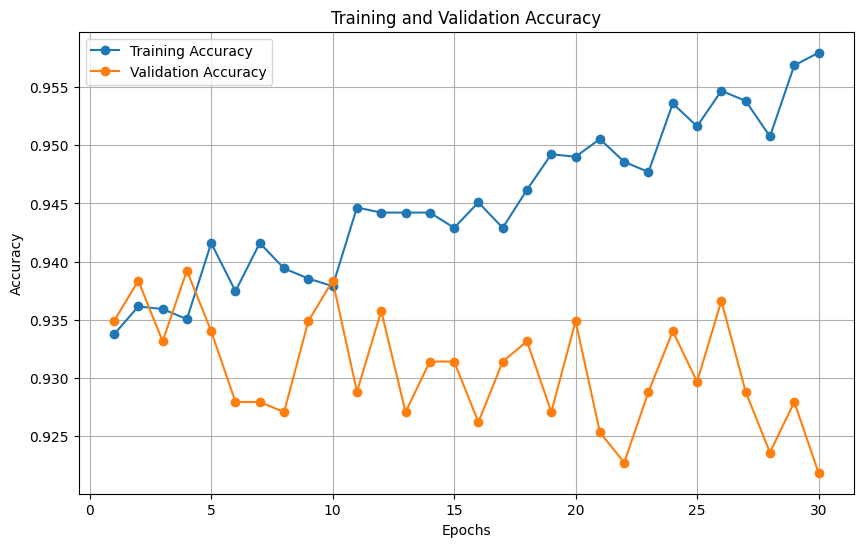

In [26]:
import matplotlib.pyplot as plt

# Extract accuracy values from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


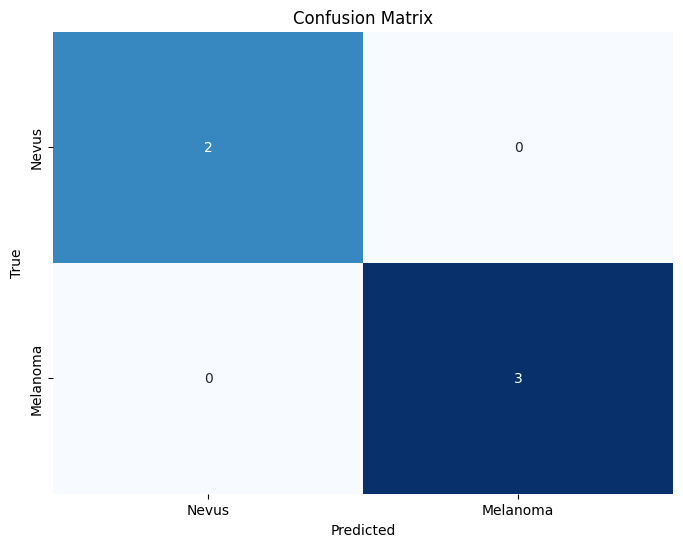

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# True labels and predicted labels ("Nevus" and "Melanoma")
true_labels = ["Nevus", "Melanoma", "Nevus", "Melanoma", ...]  # True labels
predicted_labels = ["Nevus", "Melanoma", "Nevus", "Melanoma", ...]  # Predicted labels

# Convert labels to binary (0 for "Nevus", 1 for "Melanoma")
true_labels_binary = [0 if label == "Nevus" else 1 for label in true_labels]
predicted_labels_binary = [0 if label == "Nevus" else 1 for label in predicted_labels]

# Calculate the confusion matrix
cm = confusion_matrix(true_labels_binary, predicted_labels_binary)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Nevus', 'Melanoma'], yticklabels=['Nevus', 'Melanoma'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
